In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from nltk.stem import SnowballStemmer
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import re
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I514609\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"
stemmer = SnowballStemmer('english')

stop_words = stopwords.words('english')

tokenizer = Tokenizer()
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

0    4342
1    3271
Name: target, dtype: int64


<AxesSubplot:>

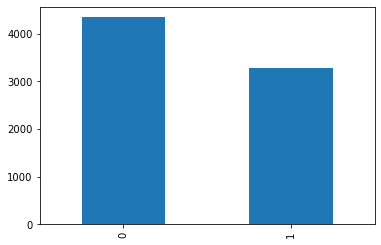

In [3]:
# Check unbalanced target data
print(train_df['target'].value_counts())
train_df['target'].value_counts().plot(kind='bar')

In [4]:
# Delete duplicate rows based on specific columns 
train_df = train_df.drop_duplicates(subset=["text"], keep='first')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [10]:
# Clean text
def clean_tweets(text, stem=False):
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [11]:
train_df["clean_text"]=train_df["text"].apply(clean_tweets)
test_df["clean_text"]=test_df["text"].apply(clean_tweets)

In [13]:
Training_Sentence_embeddings = sbert_model.encode(train_df.clean_text)
Test_Sentence_embeddings = sbert_model.encode(test_df.clean_text)

In [19]:
# Logistic Regression K-Fold Cross Validation
skf = StratifiedKFold(n_splits=4, random_state=48, shuffle=True)
accuracy=[]
y=train_df['target']
for trn_idx, test_idx in skf.split(Training_Sentence_embeddings, y):
    X_tr,X_val=Training_Sentence_embeddings[trn_idx],Training_Sentence_embeddings[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model= LogisticRegression(max_iter=1000,C=3)
    model.fit(X_tr,y_tr)
    s = model.predict(X_val)
    accuracy.append(accuracy_score(y_val, s))

In [20]:
mean_acc = np.mean(accuracy)*100
print(accuracy)
print("Cross Validated Training Set Accuracy: ", mean_acc)

[0.8098739495798319, 0.8045191802417236, 0.8003152916447714, 0.8087230688386757]
Cross Validated Training Set Accuracy:  80.58578725762506


In [22]:
# Logistic Regression K-Fold Cross Validation
skf = StratifiedKFold(n_splits=4, random_state=48, shuffle=True)
accuracy=[]
y=train_df['target']
for trn_idx, test_idx in skf.split(Training_Sentence_embeddings, y):
    X_tr,X_val=Training_Sentence_embeddings[trn_idx],Training_Sentence_embeddings[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model= ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
    model.fit(X_tr,y_tr)
    s = model.predict(X_val)
    accuracy.append(accuracy_score(y_val, s))

In [23]:
mean_acc = np.mean(accuracy)*100
print(accuracy)
print("Cross Validated Training Set Accuracy: ", mean_acc)

[0.8261554621848739, 0.8239621650026274, 0.8176563321071991, 0.8313189700472937]
Cross Validated Training Set Accuracy:  82.47732323354985


In [26]:
# BERT Classifier Prediction
result = model.predict(Test_Sentence_embeddings)
test_df['target'] = result
test_df[["id", "target"]].head()
test_df[["id", "target"]].to_csv('submission_bert.csv', index=False)